# An analysis of the State of the Union speeches - Part 4

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from collections import Counter
import shelve
from sklearn import manifold


plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (10, 6)

Again, load data we need from previous parts without redoing that work.

In [2]:
wmat = pd.read_hdf('results/df3.h5', 'wmat')
addresses = pd.read_hdf('results/df2.h5', 'addresses')

## Distance between speeches

### By President

Let's first compute a few useful things we'll need later, like the unique set of all presidents and their initials (for plot labeling).

Now, make a dataframe that will contain the word counts aggregated by president:

In [3]:
#Make pres_mat independent of wmat 
pres_mat = wmat.copy()
#Each column corresponds to a row in addresses
pres_mat.columns = addresses['president'].values
#Group the columns by president and then sum each group to aggregate
pres_mat = pres_mat.groupby(pres_mat.columns, axis = 1).sum()
#Sort presidents in order of presidency
unique_presidents = addresses['president'].unique()
pres_mat = pres_mat[unique_presidents]
#make the intiials list
president_initials = [''.join([c for c in name if c.isupper()]) for name in unique_presidents]
pres_mat.head()

,George Washington,John Adams,Thomas Jefferson,James Madison,James Monroe,John Quincy Adams,Andrew Jackson,Martin van Buren,John Tyler,James Polk,...,Lyndon B. Johnson,Richard Nixon,Gerald R. Ford,Jimmy Carter,Ronald Reagan,George H.W. Bush,William J. Clinton,George W. Bush,Barack Obama,Donald J. Trump
cavil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ship-can,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
post,13.0,2.0,4.0,3.0,34.0,16.0,23.0,3.0,5.0,11.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,4.0,3.0,0.0
"16,292,600",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"341,392,868",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


And `pmn` is a normalized version that turns counts into probability distributions:

In [4]:
pmn = pres_mat.apply(lambda x: x/np.sum(x))
pmn.head()

,George Washington,John Adams,Thomas Jefferson,James Madison,James Monroe,John Quincy Adams,Andrew Jackson,Martin van Buren,John Tyler,James Polk,...,Lyndon B. Johnson,Richard Nixon,Gerald R. Ford,Jimmy Carter,Ronald Reagan,George H.W. Bush,William J. Clinton,George W. Bush,Barack Obama,Donald J. Trump
cavil,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
ship-can,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
post,0.001572,0.000556,0.00039,0.000281,0.001662,0.001045,0.000551,0.000133,0.000296,0.000303,...,0.0,0.0,0.0,0.000036,0.000052,0.0,0.000029,0.000157,0.000093,0.0
"16,292,600",0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
"341,392,868",0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0


Sanity check: all columns should sum to 1.

In [5]:
pmn.sum()

George Washington        1.0
John Adams               1.0
Thomas Jefferson         1.0
James Madison            1.0
James Monroe             1.0
John Quincy Adams        1.0
Andrew Jackson           1.0
Martin van Buren         1.0
John Tyler               1.0
James Polk               1.0
Zachary Taylor           1.0
Millard Fillmore         1.0
Franklin Pierce          1.0
James Buchanan           1.0
Abraham Lincoln          1.0
Andrew Johnson           1.0
Ulysses S. Grant         1.0
Rutherford B. Hayes      1.0
Chester A. Arthur        1.0
Grover Cleveland         1.0
Benjamin Harrison        1.0
William McKinley         1.0
Theodore Roosevelt       1.0
William H. Taft          1.0
Woodrow Wilson           1.0
Warren Harding           1.0
Calvin Coolidge          1.0
Herbert Hoover           1.0
Franklin D. Roosevelt    1.0
Harry S. Truman          1.0
Dwight D. Eisenhower     1.0
John F. Kennedy          1.0
Lyndon B. Johnson        1.0
Richard Nixon            1.0
Gerald R. Ford

Make a numpy array version to use with Scikit-Learn:

In [6]:
pmm = pmn.as_matrix()
pmm.shape

(19140, 42)

You can use the JSdiv function below as-is, it already works.

In [7]:
from scipy.stats import entropy

def JSdiv(p, q):
    """Jensen-Shannon divergence.
    
    Compute the J-S divergence between two discrete probability distributions.
    
    Parameters
    ----------
    
    p, q : array
        Both p and q should be one-dimensional arrays that can be interpreted as discrete
        probability distributions (i.e. sum(p) == 1; this condition is not checked).
        
    Returns
    -------
    float
        The J-S divergence, computed using the scipy entropy function (with base 2) for
        the Kullback-Leibler divergence.
    """
    m = (p + q) / 2
    return (entropy(p, m, base=2.0) + entropy(q, m, base=2.0)) / 2

In [8]:
#Sinde MDS is stochastic, we set a seed to get the same results each time the notebook is run
np.random.seed(1)
divergence = np.zeros((len(unique_presidents), len(unique_presidents)))
for i in range(len(unique_presidents)):
    for j in range(len(unique_presidents)):
        divergence[i, j] = JSdiv(pmm[:, i], pmm[:, j])

#initialize
MDS_naive =  manifold.MDS()
# transform to lower dimensional representation with Euclidean distance
lower_naive = MDS_naive.fit_transform(pmm.T)

# intiialize
MDS =  manifold.MDS(dissimilarity="precomputed")
# transform to lower dimensional representation with JS distance
lower = MDS.fit_transform(divergence)

lower_df = pd.DataFrame({"x_JS":lower[:,0], "y_JS":lower[:,1],
                         "x_naive":lower_naive[:,0], "y_naive": lower_naive[:,1],
                         "President": unique_presidents})

This is a "naive" plot where we use the $L^2$ distance to build the embedding.

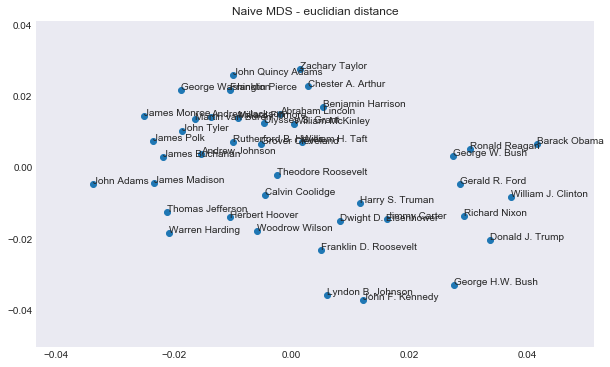

In [9]:
fig, ax = plt.subplots(1, 1)

ax.scatter(lower_df["x_naive"], lower_df["y_naive"])
ax.set_title("Naive MDS - euclidian distance")

for i, txt in enumerate(lower_df["President"]):
    ax.annotate(txt, (lower_df["x_naive"][i], lower_df["y_naive"][i]))

One interesting to note is that all presidents around the same era seem to be clustered together. For example, the "modern" presidents of Clinton, Trump, Bush, and Obama all are around each other, indicating that their word usages are pretty similar.

This will be more informative if we make a little utility function for the plots, that carries a legend, annotates each point with the president's initials, and colors them all:

In [12]:
def plot_embedding(data, title='MDS Embedding', savepath=None, palette='viridis', 
                   size=7, annotate='initials'):
    """Plot an MDS embedding dataframe for all presidents.
    
    Uses Seaborn's `lmplot` to create an x-y scatterplot of the data, encoding the 
    value of the `President` field into the hue (which can be mapped to any desired
    color palette).
    
    Parameters
    ----------
    data : DataFrame
        A DataFrame that must contain 3 columns labeled 'x', 'y' and 'President'.
        
    title : optional, string
        Title for the plot
        
    savepath : optional, string
        If given, a path to save the figure into using matplotlib's `savefig`.
        
    palette : optional, string
        The name of a valid Seaborn palette for coloring the points.
    
    size : optional, float
        Size of the plot in inches (single number, square plot)
        
    annotate: optional, 'initials', 'name' or False
        If 'initials', annotate each point with the intials of each president,
        if 'name', use their last name, and if False, do not annotate at all.
        
    Returns
    -------
    FacetGrid
        The Seaborn FacetGrid object used to create the plot.
    """
    #map each president to a color id
    unique_presidents = data["President"].unique()
    president_color = {president: i for i, president in enumerate(unique_presidents)}
    
    colors = []
    for president in data["President"]:
        colors.append(president_color[president])
    
    sns.set_style("darkgrid")
    
    s = sns.lmplot("x", "y", data = data, hue = "President", palette = palette, 
    
                   size = size, fit_reg = False, legend = False)
    ax = plt.gca()

    if len(title) > 0:
        ax.set_title(title)
        
    if annotate == 'name':
        for i, txt in enumerate(data["President"]):
            last_name = txt.split(" ")[-1]
            ax.annotate(last_name, (data["x"][i], data["y"][i]))
    elif annotate == "initials":
        for i, txt in enumerate(data["President"]):
            initials = ''.join([c for c in txt if c.isupper()])
            ax.annotate(initials, (data["x"][i], data["y"][i]))
    
    ax.legend(loc='center', bbox_to_anchor=(1.32, 0.5), ncol = 2, title = "President", bbox_transform=ax.transAxes)
    if savepath != None:
        s.fig.savefig(savepath, bbox_inches='tight')
    return s

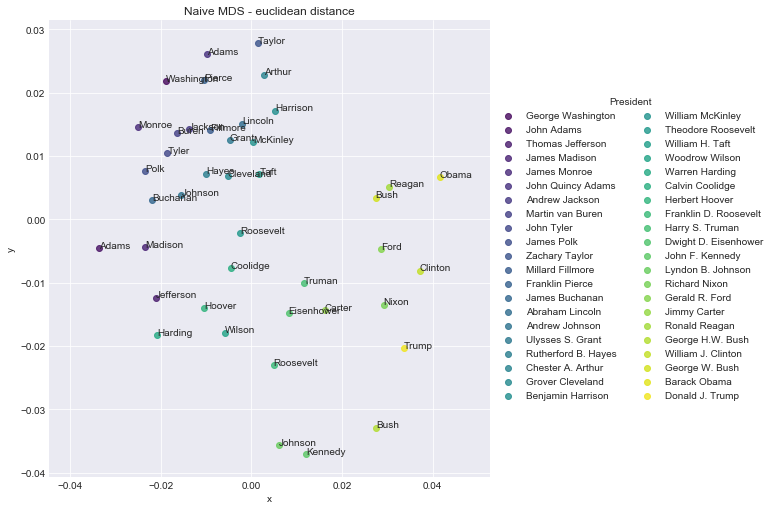

In [13]:
embed_peu = lower_df[["x_naive", "y_naive", "President"]]
embed_peu.columns = ['x', 'y', "President"]
plot_embedding(embed_peu, 'Naive MDS - euclidean distance', 'fig/mds_naive.png', annotate='name');

Yep, it is a lot clearer now that there are these clusters.

Now we use a distance metric defined on probability mass functions, the Jensen-Shannon Metric.

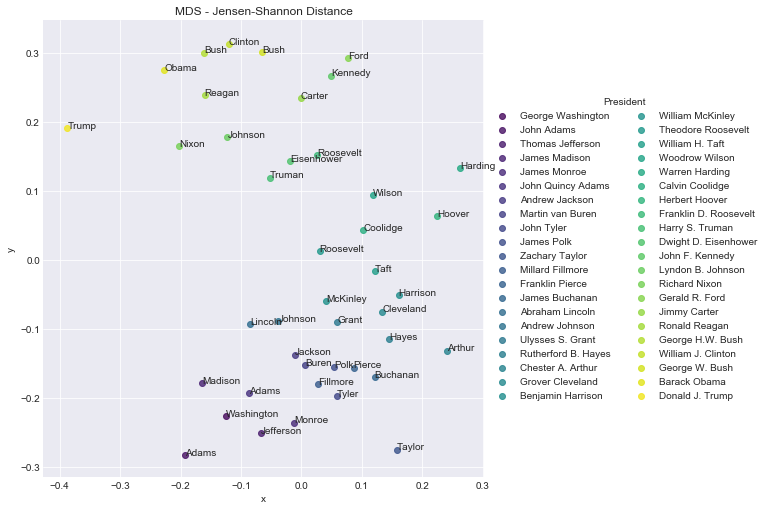

In [14]:
edf2 = lower_df[["x_JS", "y_JS", "President"]]
edf2.columns = ['x', 'y', "President"]
plot_embedding(edf2, 'MDS - Jensen-Shannon Distance', 'fig/mds_jsdiv.png', annotate='name');

We still see similar results as with the Jensen-Shannon Metric. Presidents around the same era have similar speech patterns. While this should not be surprising, it is pretty interesting to see.

### By Speech
First we normalize the term-document matrix

In [15]:
embed = wmat.copy()
#Each column corresponds to a row in addresses
embed.columns = addresses['president'].values
embed = embed.apply(lambda x: x/np.sum(x))
embed = embed.as_matrix()
divergence_individual = np.zeros((embed.shape[1], embed.shape[1]))

for i in range(embed.shape[1]):
    for j in range(embed.shape[1]):
        divergence_individual[i, j] = JSdiv(embed[:, i], embed[:, j])

MDS_naive_individual =  manifold.MDS()
# transform to lower dimensional representation with Euclidean distance
lower_naive_individual = MDS_naive_individual.fit_transform(embed.T)

# intiialize
MDS_individual =  manifold.MDS(dissimilarity="precomputed")
# transform to lower dimensional representation with JS distance
lower_individual = MDS_individual.fit_transform(divergence_individual)

df2 = pd.DataFrame({"x_JS":lower_individual[:,0], "y_JS":lower_individual[:,1],
                         "x_naive":lower_naive_individual[:,0], "y_naive": lower_naive_individual[:,1],
                         "President": addresses['president']})

We make a similar naive plot embedding using the $L^2$ distance.

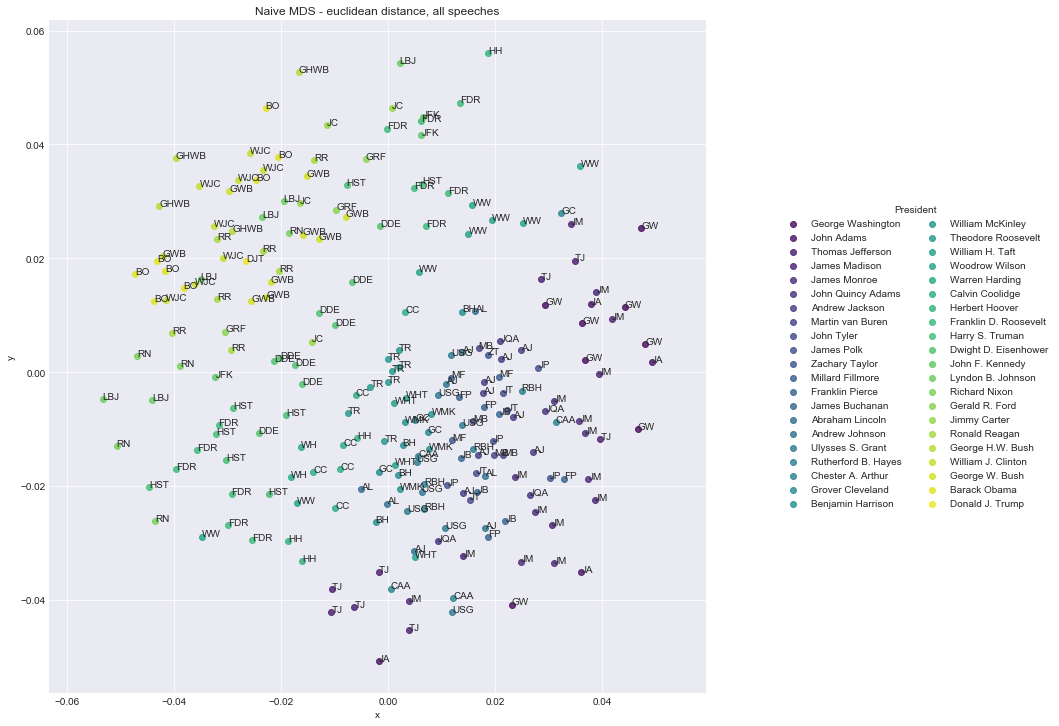

In [16]:
embed_df = df2[["x_naive", "y_naive", "President"]]
embed_df.columns = ['x', 'y', "President"]
plot_embedding(embed_df, 'Naive MDS - euclidean distance, all speeches',
               'fig/mds_naive_all.png', size=10);

We still see similar results looking at individual speeches with naive MDS with Euclidian distance.

Now with the Jensen-Shannon metric

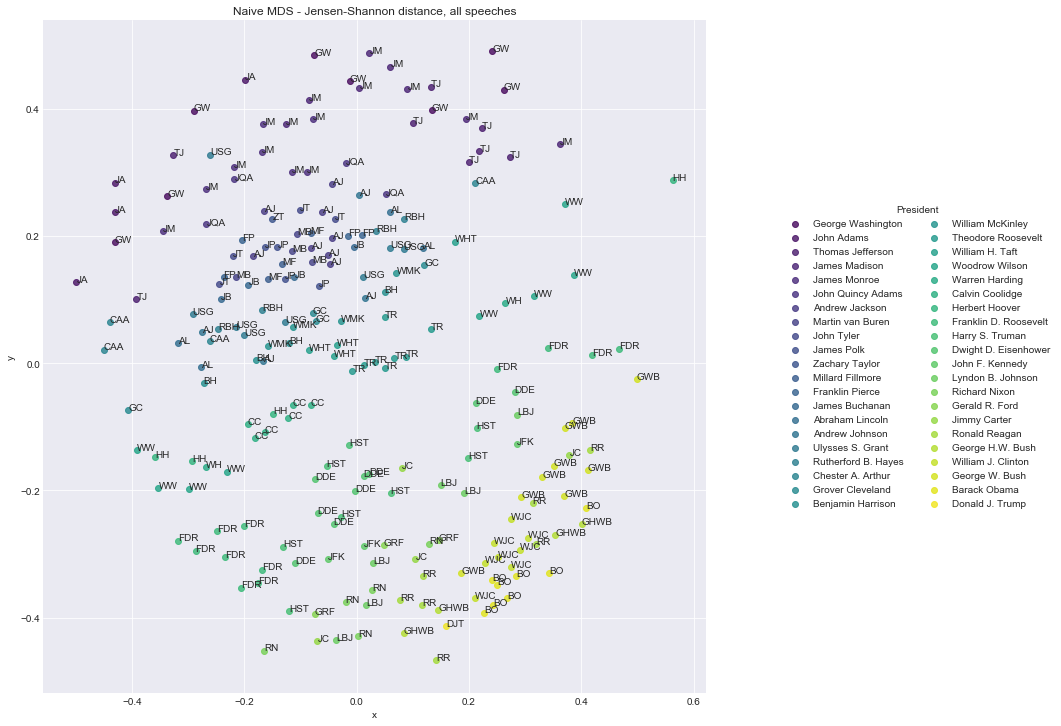

In [17]:
embed_df2 = df2[["x_JS", "y_JS", "President"]]
embed_df2.columns = ['x', 'y', "President"]
plot_embedding(embed_df2, 'Naive MDS - Jensen-Shannon distance, all speeches', 
               'fig/mds_jdsiv_all.png', size=10);

We still see similar results looking at individual speeches with naive MDS with the Jensen-Shannon Metric. In all cases, we see that presidents around the same era being clustered together. This reflects the evolution of the English language.

Store some final results. For native numpy arrays, we can use the convenient numpy `npz` container format, which behaves in practice similar to the Pandas HDF5 store and the Python Shelves:

In [18]:
np.savez('results/npa4.npz', pmm=pmm)